#Feature Learning for Video Feedback
##Victor Shepardson
###Dartmouth College Digital Musics

The goal of this project is to discover aesthetically interesting digital video feedback processes by incorporating learned features into a hand constructed feedback process.

Consider a video feedback process defined by the mapping from images to images $x_t = \Delta_\phi(x_{t-1})$, where $\Delta$ is a transition function, $\phi$ is a parameterization which may be spatially varying or interactively controlled, and $x_t$ is the image at time step $t$.

Additionally suppose we have a deep autoencoder $\gamma$ for images: $$h^{\ell+1} = \gamma_\ell(h^\ell)$$ $$h^{\ell} \approx \gamma_\ell^{-1}(h^{\ell+1})$$ $$h^0 = x$$

Combining these two concepts, we can define a new feedback process where position in the feature hierarchy acts like another spatial dimension:
$$h_t^\ell = \Delta_\phi( h_{t-1}^\ell, \gamma_{\ell-1}(h_{t-1}^{l-1}), \gamma_\ell^{-1}(h_{t-1}^{\ell+1}) )$$

The goal then is to learn a deep autoencoder which represents abstract image features and admits layer-wise encoding and decoding as above. I propose a convolutional pooling autoencoder based on the convolutional autoencoders of [Masci et al.][1] and the upsampling layers of [Long et al.][2].

Below I have trained a single layer pooled convolutional autoencoder on the CIFAR-10 dataset using [caffe][3]. The code is available at my [GitHub](https://github.com/victor-shepardson/feature-feedback). I use a filter size of 3x3x3 and 2x2 max pooling. For this experiment, the data dimensionality is preserved in the intermediate representation by using 12 filters (3 input colors x factor of 4 lost to pooling). I trained on the L2 reconstruction error with momentum but no other regularization. Test error was found to decrease consistently from about 100 at random initialization to about 1.3.

[1]: http://people.idsia.ch/~masci/papers/2011_icann.pdf "Masci, J., Meier, U., Cireşan, D., & Schmidhuber, J. (2011). Stacked convolutional auto-encoders for hierarchical feature extraction. In Artificial Neural Networks and Machine Learning–ICANN 2011 (pp. 52-59). Springer Berlin Heidelberg."

[2]: http://arxiv.org/pdf/1411.4038v1.pdf "Long, J., Shelhamer, E., & Darrell, T. (2014). Fully convolutional networks for semantic segmentation. arXiv preprint arXiv:1411.4038."

[3]: http://caffe.berkeleyvision.org/ "Caffe Deep learning framework by the BVLC"


In [4]:
#get caffe and pycaffe set up

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
%matplotlib inline

#assuming feature-feedback repo and caffe root are in the same directory
caffe_root = '../../caffe/'
import sys
sys.path.insert(0, caffe_root+'python')

import caffe
from caffe.proto import caffe_pb2
#I have compiled caffe for CPU only (nvidia GPUs only)
caffe.set_mode_cpu()

In [ ]:
# L2 reconstruction error for images may not be a fantastic idea in RGB colorspace;
# we may want to preprocess the data by converting to CIELUV or something

In [ ]:
#run this cell to solve the model defined in the solver_file
solver_file = 'autoencoder-0-solver.prototxt'
solver = caffe.get_solver(solver_file);
solver.solve();

In [24]:
#load the model trained by the previous cell
#(and saved elsewhere in the repo) and set it up on test data
model_def_file = 'autoencoder-0.prototxt'
model_file = '../bin/cifar-tanh-20epoch-unregularized.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(1.4730193614959717, dtype=float32)}

# Visualize Reconstruction
We can pull inputs and reconstructions straight out of the caffe Net and manually undo the mean subtraction:

In [9]:
#load the cifar mean into numpy array
blob = caffe_pb2.BlobProto()
data = open('../../caffe/examples/cifar10/mean.binaryproto').read()
blob.ParseFromString(data)
mean = caffe.io.blobproto_to_array(blob)[0].transpose([1,2,0])/256

In [7]:
def get_reconstructions(net, mean, n, compare=0):
    inputs = np.hstack([ np.copy(net.blobs['data'].data[i]).transpose([1,2,0])+mean for i in range(n)])
    outputs = np.hstack([ np.copy(net.blobs['decode1neuron'].data[i]).transpose([1,2,0])+mean for i in range(n)])
    #clamp the reconstruction to [0,1]
    #even with tanh activation outputs can be out of bounds once mean is added back
    np.clip(outputs, 0, 1, outputs)
    #compare to cubic resampling through the intermediate spatial resolution
    #this is a good baseline for how well spatial information is stored and 
    #recovered by the convolutional layers
    if compare>0:
        comparisons = np.dsplit(np.copy(inputs), inputs.shape[2])
        comparisons = [scipy.ndimage.zoom(np.squeeze(c), 1./compare, order=3) for c in comparisons]
        comparisons = [scipy.ndimage.zoom(c, compare, order=3) for c in comparisons]
        comparisons = np.dstack(comparisons)
        np.clip(comparisons, 0, 1, comparisons)
        return (inputs, outputs, comparisons)
    return (inputs, outputs)
def vis_reconstructions(rec):
    disp = np.vstack(rec)
    plt.imshow(disp, interpolation='None')

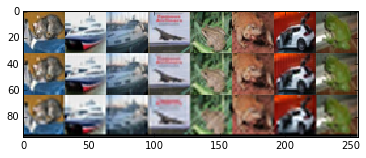

In [60]:
rec = get_reconstructions(net, mean, 8, compare=2)
vis_reconstructions(rec)

 CIFAR-10 test inputs on top, reconstructions in the middle, cubic interpolation comparison on the bottom. Looks good!

#Visualize Filters

Now let's pull our 12 3x3x3 filters out of the model

In [26]:
def get_filters(net, layer = 'encode1'):
    filters = np.copy(net.params[layer][0].data).transpose([0,2,3,1])
    biases = np.copy(net.params[layer][1].data)
    print biases
    return filters
def vis_filters(filters, rows):
    #normalize preserving 0 = 50% gray
    filters/=2*abs(filters).max()
    filters+=.5
    disp = np.hstack([np.pad(f,[(1,1),(1,1),(0,0)],'constant', constant_values=[.5]) for f in filters])
    disp = np.vstack(np.hsplit(disp,rows))
    return disp
    

[-0.36862749 -0.1923824  -0.22088723 -0.12164118 -0.10508166 -0.49331141
 -0.53125817 -0.48567948 -0.44001433 -0.39040077 -0.32423615 -0.1737113 ]


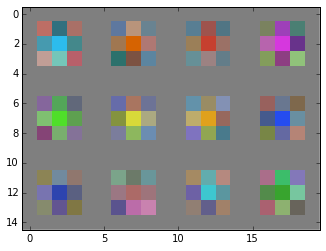

In [154]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

Looks like the network mostly learned localized primary and secondary color detectors. Weird! These aren't the usual edge filters, but they seem to at least have some plausible structure.

#Visualize filter responses

Now let's see the (max pooled) reponses of all 12 filters to a few inputs: 

In [5]:
def get_responses(net, layer, filts, n):
    reps = np.hstack([ net.blobs[layer].data[i].transpose([1,2,0]) for i in range(n)])
    # normalize preserving 0 = 50% gray
    reps/=2*abs(reps).max()
    reps+=.5
    reps = np.vstack(np.dsplit(reps, filts))
    return reps.squeeze()    
def vis_responses(reps):
    plt.figure(figsize=(10,10))
    plt.imshow(reps, interpolation='none', cmap='coolwarm')

(192, 128, 1)


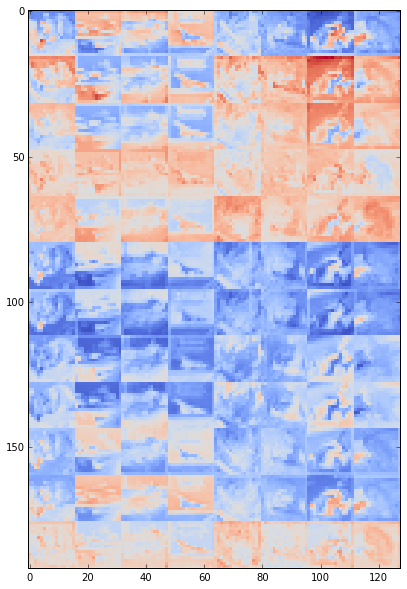

In [156]:
reps = get_responses(net, 'pool1', 12, 8)
vis_responses(reps)

Pooled activations for each of 12 filters. Red is positive response, blue negative.

#Dimensionality Reduction

Let's try fewer filters, reducing dimensionality in the intermediate representation

In [3]:
solver_file = 'autoencoder-1-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [66]:
model_def_file = 'autoencoder-1.prototxt'
model_file = '../bin/cifar-tanh-20epoch-squeezing.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(2.5404462814331055, dtype=float32)}

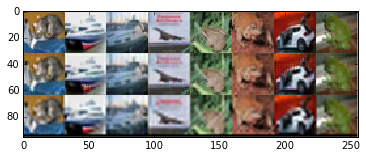

In [67]:
rec = get_reconstructions(net, mean, 8, compare=2)
vis_reconstructions(rec)

This time there's some clear loss of detail. The filters are doing something, though; looks better than cubic interpolation

[-0.09201549 -0.12697266 -0.11692226 -0.10681173 -0.09015708 -0.11839788]


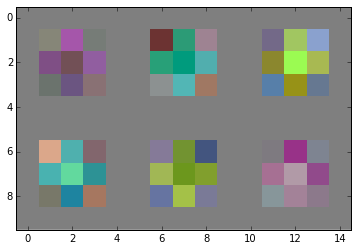

In [24]:
filters = get_filters(net)
disp = vis_filters(filters, 2)
plt.imshow(disp, interpolation='none')

These filters appear to be learning color gradients in a subtractive color space

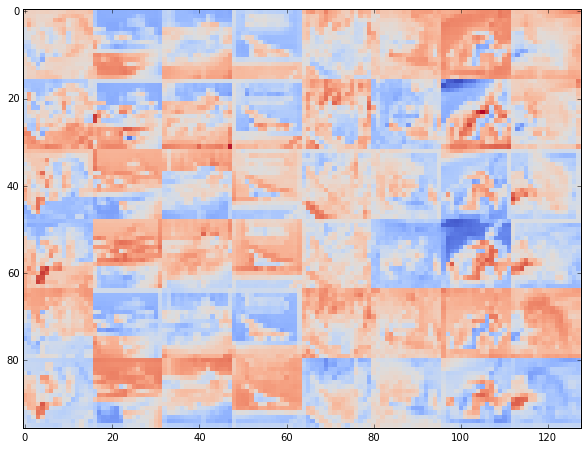

In [31]:
reps = get_responses(net, 'pool1', 6, 8)
vis_responses(reps)

# Another Architecture

What about more aggressively reshaping the data within a single layer? How about larger 5x5 filters, 4x4 pooling, and the corresponding large number of filters (3x4x4 = 48)

In [ ]:
solver_file = 'autoencoder-2-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve('autoencoder-2_iter_20000.solverstate')

In [3]:
model_def_file = 'autoencoder-2.prototxt'
#model_file = '../bin/cifar-tanh-20epoch-squeezing-pool3.caffemodel'
model_file = 'autoencoder-2_iter_20000.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(5.954926013946533, dtype=float32)}

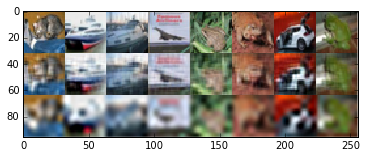

In [10]:
rec = get_reconstructions(net, mean, 8, compare=4)
vis_reconstructions(rec)

This looks worse than the dimensionality reducing version even. By 40 epochs training had slowed to a crawl.

[-0.5458473  -0.85954159 -0.10250413 -0.11447078 -0.01339798 -0.31032813
 -0.02660202 -0.77891278  0.04860483  0.17118894 -0.18338218  0.03620156
 -0.21440832 -0.74913269 -0.677212   -0.11030301 -0.01261417 -0.31087366
 -0.56522584 -0.5849033  -0.3219969  -0.14499842  0.04703386 -0.71903616
 -0.64787728 -0.12493432 -0.73442465 -0.80459327 -0.23484692 -0.03186548
  0.02129112 -0.08047031 -0.23331846 -0.149628   -0.72716242 -0.1825075
  0.12050974 -0.21958451 -0.36699957 -0.15040933  0.08417189 -0.1206205
 -0.59321886  0.01488551 -0.28670374 -0.62786371  0.13887869 -0.20581132]


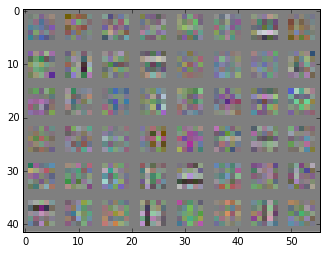

In [12]:
filters = get_filters(net)
disp = vis_filters(filters, 6)
plt.imshow(disp, interpolation='none')

These filters look like noisy edge detectors. Something prevented the training from finding a good  minimum

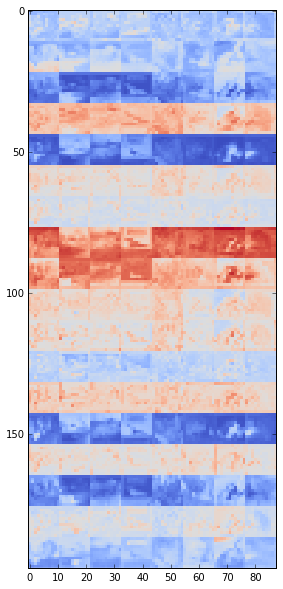

In [14]:
reps = get_responses(net, 'pool1', 18, 8)
vis_responses(reps)

#Better Reconstruction

How many parameters do we need to get near-perfect reconstruction with a single layer? Let's step the orginal 2x2 pooling architecture up to 5x5 filters, leaving the reconstruction filters alone.

In [ ]:
solver_file = 'autoencoder-6-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve('autoencoder-6_iter_10000.solverstate')

In [10]:
model_def_file = 'autoencoder-6.prototxt'
model_file = 'autoencoder-6_iter_20000.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(1.173688292503357, dtype=float32)}

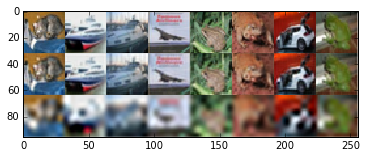

In [11]:
rec = get_reconstructions(net, mean, 8, compare=4)
vis_reconstructions(rec)

[-0.13053145 -0.51994026 -0.13268141 -0.24337031 -0.35381192 -0.31960326
 -0.1194208  -0.48448056 -0.23158208 -0.30801979 -0.3582561  -0.30901095]


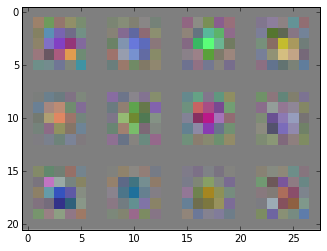

In [12]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

Interesting--these look like 3x3 filters with a random fringe. Curiously it learned better than the first architecture above, even though the extra pixels appear to be wasted. Perhaps it got a better random initialization, or the filter noisiness acts like a kind of regularization. It may have learned small filters because the reconstruction filter size was too small. Let's bump that up too:

In [9]:
solver_file = 'autoencoder-7-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve('autoencoder-7_iter_10000.solverstate')

In [5]:
model_def_file = 'autoencoder-7.prototxt'
model_file = 'autoencoder-7_iter_40000.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(0.9563984870910645, dtype=float32)}

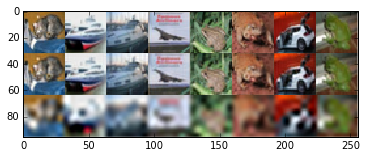

In [10]:
rec = get_reconstructions(net, mean, 8, compare=4)
vis_reconstructions(rec)

[-0.12125222 -0.08644268 -0.33110973 -0.0643307  -0.09994981 -0.36133596
 -0.30555385 -0.06790387 -0.26083776 -0.45829996 -0.09892169 -0.32911256]


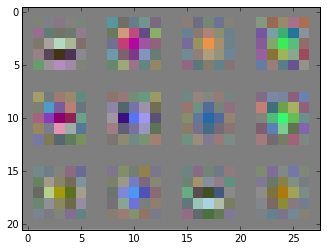

In [27]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

The more expressive decoder did reduce error and visual fidelity is now very close to perfect. It did not change the noisy-fringed character of the learned filters. The center filters are mostly in pairs which appear to be mirrors, rotations and/or or color inverses. neat!

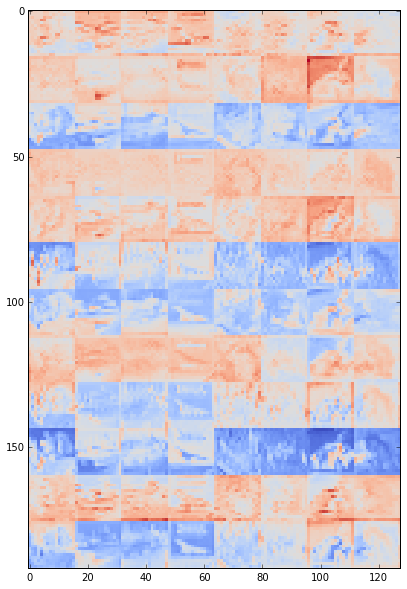

In [16]:
reps = get_responses(net, 'pool1', 12, 8)
vis_responses(reps)

We could keep going to 7x7 encoders and 8x8 decoders; but at some point I expect larger filters to have trouble with CIFAR since the images are so tiny. With 7x7 filters about half of all convolutions are going to include some padding.

#Dump to texture
Let's dump the weights from the best 1-layer model to an image file so openFrameworks can load them into OpenGL

In [37]:
def dump_to_img(net, nlayers):
    for l in range(1, nlayers+1):
        encode_name = 'encode'+str(l)
        decode_name = 'decode'+str(l)
        #move source channel to innermost dimension
        filters = np.copy(net.params[encode_name][0].data).transpose([0,2,3,1])
        biases = np.copy(net.params[encode_name][1].data)
        np.save(encode_name+'-filters', filters)
        np.save(encode_name+'-biases', biases)
        filters = np.copy(net.params[decode_name][0].data).transpose([1,2,3,0])
        biases = np.copy(net.params[decode_name][1].data)
        np.save(decode_name+'-filters', filters)
        np.save(decode_name+'-biases', biases)

In [38]:
dump_to_img(net, 1)

[ 0.02533275  0.01800798  0.04170697]


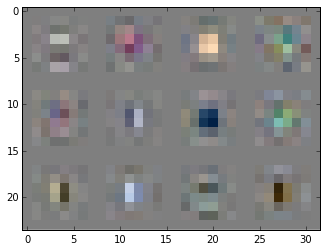

In [43]:
#get_filters(net)
#np.copy(net.params['decode1'][0].data).transpose([1,2,3,0])
filters = get_filters(net, 'decode1')
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

#Deeper Network

Let's try stacking another layer on the last architecture, above. We'll freeze the first encoder/decoder and treat the first pooling layer as input to a new autoencoder.

In [ ]:
solver_file = 'autoencoder-8-solver.prototxt'
solver = caffe.get_solver(solver_file)
#initialize the first layer with previously trained weights
#first let's try stacking with the lower weights frozen
pre_net = caffe.Net('autoencoder-7.prototxt', 'autoencoder-7_iter_40000.caffemodel', caffe.TEST)
for layer in ['encode1', 'decode1']:
    solver.net.params[layer][0].data[:] = pre_net.params[layer][0].data
    solver.net.params[layer][1].data[:] = pre_net.params[layer][1].data
solver.solve()

In [7]:
model_def_file = 'autoencoder-8.prototxt'
#model_file = '../bin/cifar-tanh-20epoch-2layer.caffemodel'
model_file = 'autoencoder-8_iter_40000.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error1': array(5.685671329498291, dtype=float32),
 'l2_error2': array(2.0855603218078613, dtype=float32)}

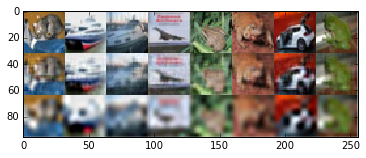

In [8]:
rec = get_reconstructions(net, mean, 8, compare=4)
vis_reconstructions(rec)

The loss for the new layer went pretty low, but the overall reconstruction error is high. Let's try fine tuning on all weights with original L2 reconstruction error

In [2]:
solver_file = 'autoencoder-9-solver.prototxt'
solver = caffe.get_solver(solver_file)
#initialize the first layer with previously trained weights
#this time bring over all the parameters
pre_net = caffe.Net('autoencoder-8.prototxt', 'autoencoder-8_iter_40000.caffemodel', caffe.TEST)
for layer in ['encode1', 'decode1', 'encode2', 'decode2']:
    solver.net.params[layer][0].data[:] = pre_net.params[layer][0].data
    solver.net.params[layer][1].data[:] = pre_net.params[layer][1].data
solver.solve()

In [6]:
model_def_file = 'autoencoder-9.prototxt'
model_file = '../bin/cifar-tanh-60epoch-2layer-finetuned-dualobjective.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error1': array(3.2483773231506348, dtype=float32),
 'l2_error2': array(0.21920974552631378, dtype=float32)}

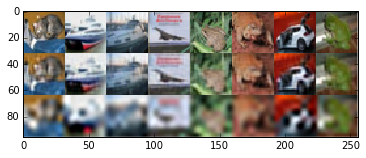

In [8]:
rec = get_reconstructions(net, mean, 8, compare=4)
vis_reconstructions(rec)

Fine tuning reduced both parts of the loss, but still looks much worse than the single layer model

[ 0.05174831 -0.02071226 -0.15018784  0.01387358  0.00702072 -0.02757885
 -0.11727612  0.00808964  0.01447153 -0.16562356  0.06779021 -0.09179834]


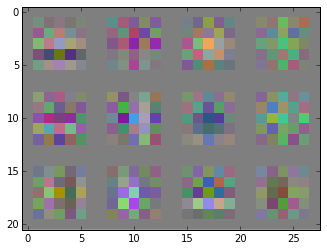

In [7]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

Fine tuning on the first layer appears to have corrupted the nice filters we had before

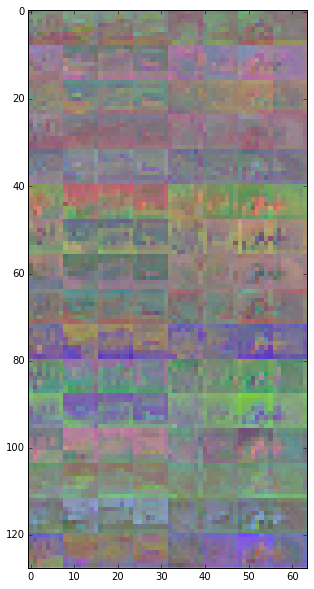

In [9]:
#map triples of filters to colors
reps = get_responses(net, 'pool2', 16, 8)
vis_responses(reps)

#Going Deeper

Can we train 3 layers from scratch?

In [17]:
solver_file = 'autoencoder-4-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [18]:
model_def_file = 'autoencoder-4.prototxt'
model_file = '../bin/cifar-tanh-40epoch-3layer.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(6.462570667266846, dtype=float32)}

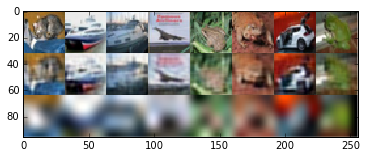

In [19]:
rec = get_reconstructions(net, mean, 8, compare=8)
vis_reconstructions(rec)

Again, we are recovering a lot of spatial detail. Deeper is still worse, will be interesting to see how heavier training improves the situation

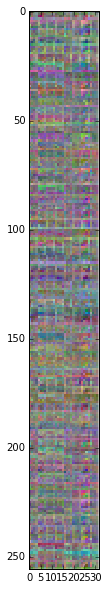

In [20]:
#map triples of filters to colors
reps = get_responses(net, 'pool3', 64, 8)
vis_responses(reps)

[  2.43100571e-03  -2.35213377e-02   2.02042498e-02  -2.02219877e-02
  -3.02740522e-02  -6.09966228e-04   1.50828494e-03   1.43372146e-02
   2.37179417e-02   2.72328760e-02  -5.83042763e-03   4.77930262e-05]


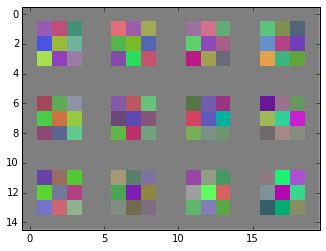

In [21]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

~~These first-layer filters are hard to interpret, but do seem to have some internal color coordination and symmetry.~~ Most deep convolutional architectures start with a large number of filters; maybe having just 4x the number of colors is asking each filter to do too many things. Then again, maybe that isn't a problem for anything besides filter visualization.

##update

Using Adagrad gave similar error, but much more random looking filters, above

#Rectifiers

ReLUs have helped to train very deep networks. For a classifier, it's not a problem to have zero mean inputs but nonnegative hidden+output layers. For this application, we rely on hidden layers having the same image properties as the input. Can we get rid of the mean subtraction and use a non negative image representation with ReLU instead of tanh units? Let's start back at the 1-layer, dimensionality preserving autoencoder:

In [13]:
solver_file = 'autoencoder-5-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [14]:
model_def_file = 'autoencoder-5.prototxt'
model_file = '../bin/cifar-relu-20epoch.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(3.137385845184326, dtype=float32)}

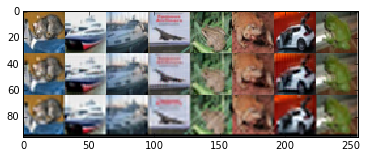

In [15]:
rec = get_reconstructions(net, np.zeros(mean.shape), 8, compare=2)
vis_reconstructions(rec)

The ReLU units work with either a reduced learning rate or increased lr and the Adagrad solver, though still not quite as well as tanh units.

[-0.00570135 -0.01200322  0.01738192 -0.0238696   0.07345211  0.0205862
  0.02235054 -0.01281478  0.03866118 -0.01633324  0.00320861  0.14468348]


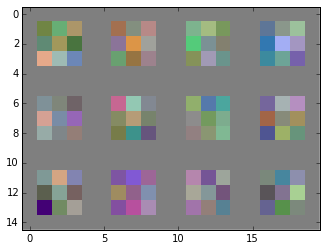

In [16]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')